In [31]:
import nilearnx as nlx
from nilearnx import image as img
from nilearnx.datasets import load_mni152_brain_maskX
import pandas as pd
import nibabel as nib
import numpy as np
from tqdm import tqdm
from numpy import ma
from nilearnx.extensions import normalize_to_quantile
tqdm.pandas()

se_map = normalize_to_quantile(img.load_img('se_maps/status_epilepticus_t5_pos.nii.gz'))
mglur5 = normalize_to_quantile(img.load_img('gene_maps/GRM5.nii.gz'))
validation_data = pd.read_csv('csvs/salzburg_filelist.csv')

In [42]:
def load_nifti_image(map_input):
    if not isinstance(map_input, nib.Nifti1Image):
        map_input = img.load_img(map_input)
    return map_input

def correlate_maps(map1, map2):
    map1 = load_nifti_image(map1)
    map2 = load_nifti_image(map2)
    mask = load_mni152_brain_maskX(resolution=2)
    map1 = img.resample_to_img(map1, mask)
    map2 = img.resample_to_img(map2, mask)
    map1 = img.math_img("np.nan_to_num(img1)", img1=map1)
    map2 = img.math_img("np.nan_to_num(img1)", img1=map2)
    map1 = nlx.image.math_img("np.maximum(img, 0)", img=map1)
    map2 = nlx.image.math_img("np.maximum(img, 0)", img=map2)
    correlation = np.corrcoef(map1.get_fdata().ravel(), map2.get_fdata().ravel())[0, 1]
    return correlation

def calculate_network_damage(lesion_mask, network_map, threshold=.75):
    """Calculates the network damage score for a given lesion

    Parameters
    ----------
    lesion_mask : niimg-like
        Mask of the lesion
    network_mask : niimg-like
        Network map of interest
    calculation : function
        A function used to calculate the damage score
    sign_thr : str
        specifies which sign values to consider. Can either be 'pos', 'neg', or 'both'.

    Returns
    -------
    float : network damage score

    """
    lesion_data = lesion_mask.get_fdata()
    net_data = network_map.get_fdata()
    if lesion_data.min() < 0:
        print("Warning: negative weights")
    masked_data = np.multiply(lesion_data, net_data)
    thr_mask = ma.masked_where(masked_data < threshold, masked_data)
    return np.sum(thr_mask) #/ (np.count_nonzero(thr_mask) + .00001 )


# validation_data['corr_mglur5'] = validation_data['t'].progress_apply(lambda x: correlate_maps(x, mglur5))
# validation_data['corr_se'] = validation_data['t'].progress_apply(lambda x: correlate_maps(x, se_map))
validation_data['damage_mglur5'] = validation_data['roi_2mm'].progress_apply(lambda x: calculate_network_damage(nib.load(x), mglur5))
validation_data['damage_se'] = validation_data['roi_2mm'].progress_apply(lambda x: calculate_network_damage(nib.load(x), se_map))

100%|██████████| 166/166 [00:04<00:00, 38.63it/s]


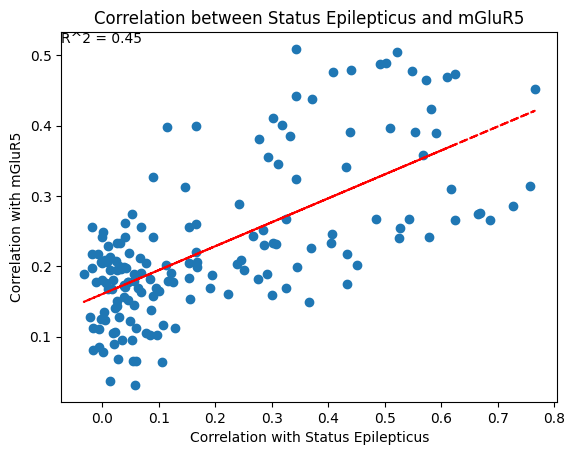

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Scatter plot
plt.scatter(validation_data['corr_se'], validation_data['corr_mglur5'])
plt.xlabel('Correlation with Status Epilepticus')
plt.ylabel('Correlation with mGluR5')
plt.title('Correlation between Status Epilepticus and mGluR5')

# Calculate trendline
z = np.polyfit(validation_data['corr_se'], validation_data['corr_mglur5'], 1)
p = np.poly1d(z)
plt.plot(validation_data['corr_se'], p(validation_data['corr_se']), "r--")

# Calculate R-squared
correlation_matrix = np.corrcoef(validation_data['corr_se'], validation_data['corr_mglur5'])
correlation_coefficient = correlation_matrix[0, 1]
r_squared = correlation_coefficient ** 2

# Add R-squared to the plot
plt.text(plt.xlim()[0], plt.ylim()[1], f'R^2 = {r_squared:.2f}', ha='left', va='top')

plt.show()

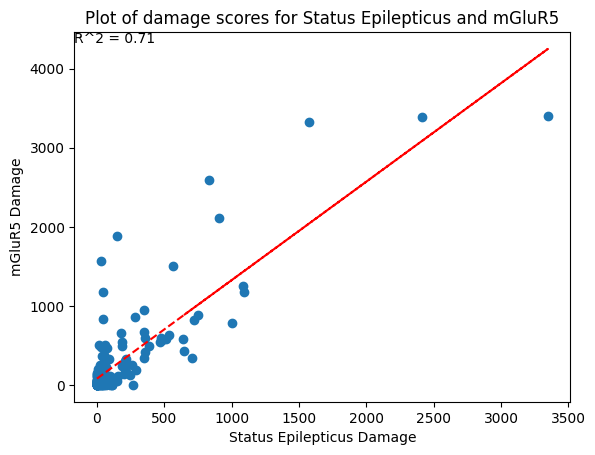

In [43]:
import numpy as np
import matplotlib.pyplot as plt

validation_data_copy = validation_data.copy()
# Filter out rows where either damage score is greater than 5000
validation_data_copy = validation_data_copy[validation_data_copy['damage_se'] < 3500]
validation_data_copy = validation_data_copy[validation_data_copy['damage_mglur5'] < 3500]

# Scatter plot
plt.scatter(validation_data_copy['damage_se'], validation_data_copy['damage_mglur5'])
plt.xlabel('Status Epilepticus Damage')
plt.ylabel('mGluR5 Damage')
plt.title('Plot of damage scores for Status Epilepticus and mGluR5')

# Calculate trendline
z = np.polyfit(validation_data_copy['damage_se'], validation_data_copy['damage_mglur5'], 1)
p = np.poly1d(z)
plt.plot(validation_data_copy['damage_se'], p(validation_data_copy['damage_se']), "r--")

# Calculate R-squared
correlation_matrix = np.corrcoef(validation_data_copy['damage_se'], validation_data_copy['damage_mglur5'])
correlation_coefficient = correlation_matrix[0, 1]
r_squared = correlation_coefficient ** 2

# Add R-squared to the plot
plt.text(plt.xlim()[0], plt.ylim()[1], f'R^2 = {r_squared:.2f}', ha='left', va='top')

plt.show()